<a href="https://colab.research.google.com/github/AnjaliSharmaTiwari/LandCoverClassification/blob/main/TransformerComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip EuroSAT.zip -d EuroSAT/

Streaming output truncated to the last 5000 lines.
  inflating: EuroSAT/2750/SeaLake/SeaLake_2206.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_1313.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_263.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_967.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_515.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_1465.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_1817.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_2902.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_2570.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_1004.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_174.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_2111.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_2388.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_1948.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_838.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_2738.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_1999.jpg  
  inflating: EuroSAT/2750/SeaLake/SeaLake_2359.jpg  


In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(batch):
  images, labels = zip(*batch)
  return list(images), torch.tensor(labels)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    AutoModelForPreTraining,
    AutoModel,
    VitMatteForImageMatting
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = "/content/EuroSAT/2750"

dataset = datasets.ImageFolder(root=data_dir)
classes = dataset.classes
num_classes = len(classes)
print("Classes:", classes)

valid_size = 0.2
batch_size = 32
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_data))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=valid_sampler,
    collate_fn=collate_fn
)

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
def train_one_epoch(model, processor, dataloader, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        labels = labels.to(device)
        inputs = processor(images, return_tensors="pt").to(device)

        outputs = model(**inputs, labels=labels)
        loss = outputs["loss"]
        logits = outputs["logits"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def validate(model, processor, dataloader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            labels = labels.to(device)
            inputs = processor(images, return_tensors="pt").to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs["loss"]
            logits = outputs["logits"]

            val_loss += loss.item() * labels.size(0)
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= total
    val_acc = 100.0 * correct / total
    return val_loss, val_acc

def evaluate_model(model, processor, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            labels = labels.to(device)
            inputs = processor(images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            logits = outputs["logits"]
            _, predicted = logits.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

def plot_confusion_matrix(all_labels, all_preds, classes):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
    plt.title("Confusion Matrix on Validation Set")
    plt.show()

def print_classification_report(all_labels, all_preds, classes):
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("Classification Report:\n", report)

In [ ]:
def get_deit_model(num_classes):
    from transformers import AutoImageProcessor, AutoModelForImageClassification
    processor = AutoImageProcessor.from_pretrained(
        "facebook/deit-small-patch16-224",
        use_fast=True
    )
    model = AutoModelForImageClassification.from_pretrained(
        "facebook/deit-small-patch16-224",
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    model.to(device)
    return model, processor


In [ ]:
def train_and_evaluate(model, processor, train_loader, valid_loader, epochs=35, lr=1e-3, wd=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    best_val_acc = 0.0
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    best_model_state = None

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, processor, train_loader, optimizer)
        val_loss, val_acc = validate(model, processor, valid_loader)

        scheduler.step()

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

    all_labels, all_preds = evaluate_model(model, processor, valid_loader)
    plot_confusion_matrix(all_labels, all_preds, classes)
    print_classification_report(all_labels, all_preds, classes)

    return best_val_acc

=== DeiT ===


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/35]
Train Loss: 1.0575, Train Acc: 61.33%
Val Loss: 0.5927, Val Acc: 79.37%

Epoch [2/35]
Train Loss: 0.5349, Train Acc: 81.68%
Val Loss: 0.4692, Val Acc: 82.81%

Epoch [3/35]
Train Loss: 0.4021, Train Acc: 86.06%
Val Loss: 0.3595, Val Acc: 87.78%

Epoch [4/35]
Train Loss: 0.3031, Train Acc: 89.33%
Val Loss: 0.2812, Val Acc: 90.39%

Epoch [5/35]
Train Loss: 0.2382, Train Acc: 91.73%
Val Loss: 0.2684, Val Acc: 90.61%

Epoch [6/35]
Train Loss: 0.1827, Train Acc: 93.86%
Val Loss: 0.3171, Val Acc: 88.96%

Epoch [7/35]
Train Loss: 0.1227, Train Acc: 95.76%
Val Loss: 0.1730, Val Acc: 94.24%

Epoch [8/35]
Train Loss: 0.0690, Train Acc: 97.57%
Val Loss: 0.1726, Val Acc: 94.43%

Epoch [9/35]
Train Loss: 0.0309, Train Acc: 99.01%
Val Loss: 0.1829, Val Acc: 95.22%

Epoch [10/35]
Train Loss: 0.0111, Train Acc: 99.75%
Val Loss: 0.1814, Val Acc: 95.39%

Epoch [11/35]
Train Loss: 0.0064, Train Acc: 99.90%
Val Loss: 0.1814, Val Acc: 95.39%

Epoch [12/35]
Train Loss: 0.0061, Train Acc: 99.91%


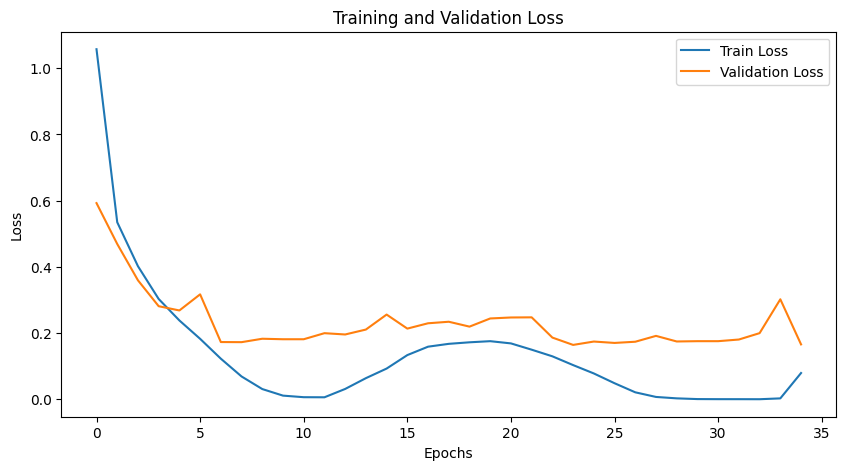

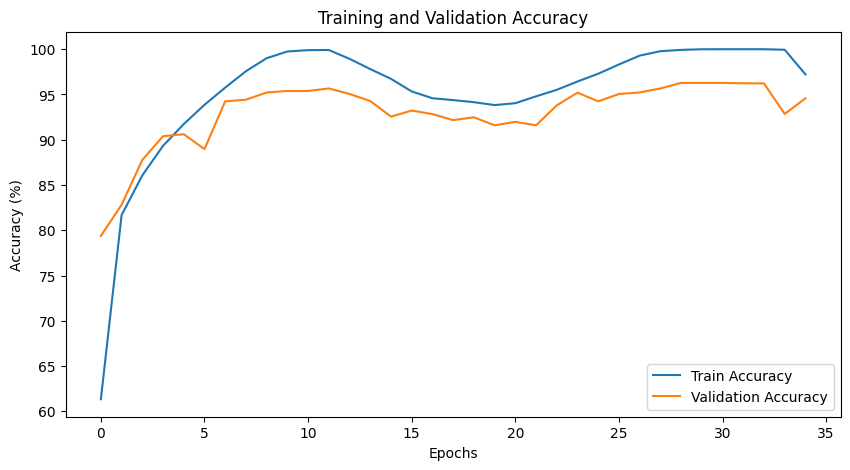

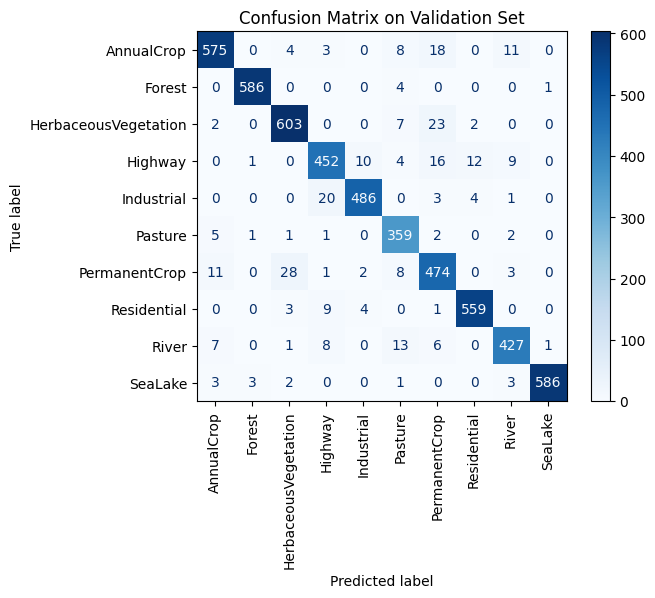

Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.95      0.93      0.94       619
              Forest       0.99      0.99      0.99       591
HerbaceousVegetation       0.94      0.95      0.94       637
             Highway       0.91      0.90      0.91       504
          Industrial       0.97      0.95      0.96       514
             Pasture       0.89      0.97      0.93       371
       PermanentCrop       0.87      0.90      0.89       527
         Residential       0.97      0.97      0.97       576
               River       0.94      0.92      0.93       463
             SeaLake       1.00      0.98      0.99       598

            accuracy                           0.95      5400
           macro avg       0.94      0.94      0.94      5400
        weighted avg       0.95      0.95      0.95      5400

DeiT Val Acc: 96.28%


In [ ]:
print("=== DeiT ===")
deit_model, deit_processor = get_deit_model(num_classes)
deit_acc = train_and_evaluate(deit_model, deit_processor, train_loader, valid_loader)

print(f"DeiT Val Acc: {deit_acc:.2f}%")

In [ ]:
def get_swin_model(num_classes):
    from transformers import AutoImageProcessor, AutoModelForImageClassification
    processor = AutoImageProcessor.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        use_fast=True
        )
    model = AutoModelForImageClassification.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=num_classes,
        ignore_mismatched_sizes=True
        )
    model.to(device)
    return model, processor

In [ ]:
print("=== Swin Transformer ===")
swin_model, swin_processor = get_swin_model(num_classes)
swin_acc = train_and_evaluate(swin_model, swin_processor, train_loader, valid_loader)

=== Swin Transformer ===


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [ ]:
def get_levit_model(num_classes):
    from transformers import LevitImageProcessor, LevitForImageClassification
    processor = LevitImageProcessor.from_pretrained(
        "facebook/levit-128S",
        use_fast=True
        )
    model = LevitForImageClassification.from_pretrained(
        "facebook/levit-128S",
        num_labels=num_classes,
        ignore_mismatched_sizes=True
        )
    model.to(device)
    return model, processor

=== LeViT Model ===


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/268 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/32.1M [00:00<?, ?B/s]

Some weights of LevitForImageClassification were not initialized from the model checkpoint at facebook/levit-128S and are newly initialized because the shapes did not match:
- classifier.linear.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.linear.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/35]
Train Loss: 0.4418, Train Acc: 86.33%
Val Loss: 0.2518, Val Acc: 92.50%

Epoch [2/35]
Train Loss: 0.1865, Train Acc: 93.87%
Val Loss: 0.3910, Val Acc: 86.96%

Epoch [3/35]
Train Loss: 0.1591, Train Acc: 94.75%
Val Loss: 0.1710, Val Acc: 94.44%

Epoch [4/35]
Train Loss: 0.1033, Train Acc: 96.52%
Val Loss: 0.1366, Val Acc: 95.61%

Epoch [5/35]
Train Loss: 0.0770, Train Acc: 97.35%
Val Loss: 0.1087, Val Acc: 96.63%

Epoch [6/35]
Train Loss: 0.0480, Train Acc: 98.46%
Val Loss: 0.1100, Val Acc: 96.67%

Epoch [7/35]
Train Loss: 0.0266, Train Acc: 99.20%
Val Loss: 0.0759, Val Acc: 97.67%

Epoch [8/35]
Train Loss: 0.0137, Train Acc: 99.59%
Val Loss: 0.0614, Val Acc: 98.06%

Epoch [9/35]
Train Loss: 0.0064, Train Acc: 99.85%
Val Loss: 0.0615, Val Acc: 98.31%

Epoch [10/35]
Train Loss: 0.0044, Train Acc: 99.91%
Val Loss: 0.0589, Val Acc: 98.31%

Epoch [11/35]
Train Loss: 0.0032, Train Acc: 99.94%
Val Loss: 0.0591, Val Acc: 98.31%

Epoch [12/35]
Train Loss: 0.0031, Train Acc: 99.94%


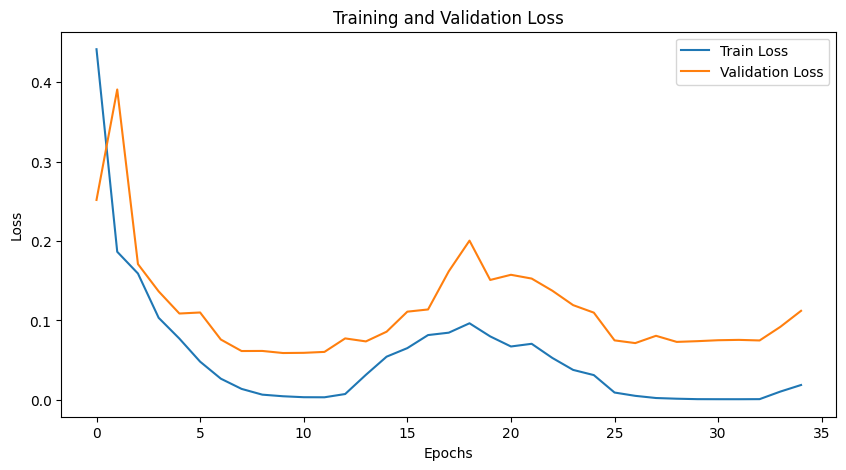

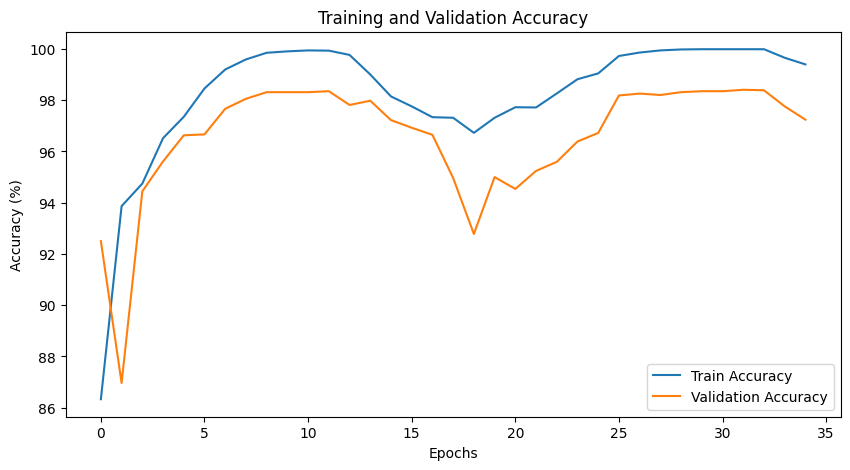

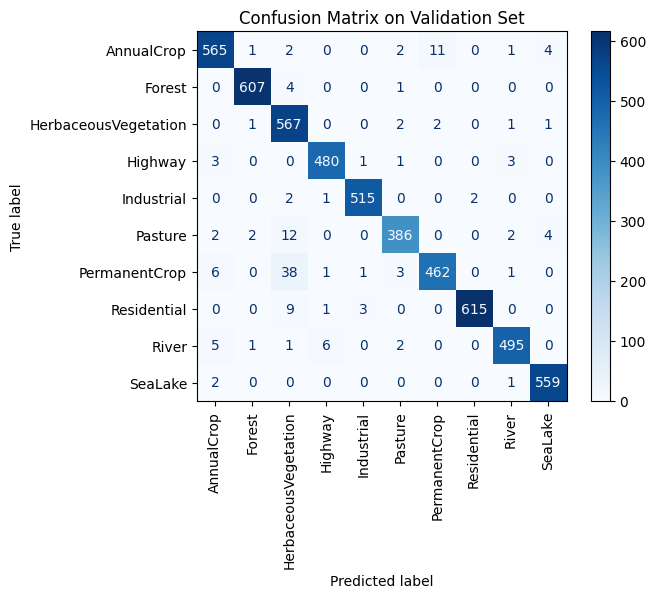

Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.97      0.96      0.97       586
              Forest       0.99      0.99      0.99       612
HerbaceousVegetation       0.89      0.99      0.94       574
             Highway       0.98      0.98      0.98       488
          Industrial       0.99      0.99      0.99       520
             Pasture       0.97      0.95      0.96       408
       PermanentCrop       0.97      0.90      0.94       512
         Residential       1.00      0.98      0.99       628
               River       0.98      0.97      0.98       510
             SeaLake       0.98      0.99      0.99       562

            accuracy                           0.97      5400
           macro avg       0.97      0.97      0.97      5400
        weighted avg       0.97      0.97      0.97      5400



In [ ]:
print("=== LeViT Model ===")
levit_model, levit_processor = get_levit_model(num_classes)
levit_acc = train_and_evaluate(levit_model, levit_processor, train_loader, valid_loader)

In [ ]:
def get_mae_model(num_classes):
    from transformers import AutoImageProcessor, AutoModelForPreTraining
    processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-large", use_fast=True)
    pretrained_model = AutoModelForPreTraining.from_pretrained("facebook/vit-mae-large")
    base_model = pretrained_model.vit

    classification_head = nn.Linear(base_model.config.hidden_size, num_classes)

    class MAEForClassification(nn.Module):
        def __init__(self, base_model, classification_head):
            super().__init__()
            self.base_model = base_model
            self.classifier = classification_head

        def forward(self, pixel_values, labels=None):
            outputs = self.base_model(pixel_values=pixel_values)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            logits = self.classifier(pooled_output)
            loss = None
            if labels is not None:
                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

    model = MAEForClassification(base_model, classification_head).to(device)
    return model, processor


In [ ]:
print("=== MAE ===")
mae_model, mae_processor = get_mae_model(num_classes)
mae_acc = train_and_evaluate(mae_model, mae_processor, train_loader, valid_loader)

=== MAE ===


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Epoch [1/35]
Train Loss: 1.4076, Train Acc: 47.71%
Val Loss: 0.9601, Val Acc: 66.15%

Epoch [2/35]
Train Loss: 0.9225, Train Acc: 66.90%
Val Loss: 0.7878, Val Acc: 71.20%

Epoch [3/35]
Train Loss: 0.8113, Train Acc: 71.41%
Val Loss: 1.0187, Val Acc: 63.76%

Epoch [4/35]
Train Loss: 0.7102, Train Acc: 75.03%
Val Loss: 0.6611, Val Acc: 75.61%

Epoch [5/35]
Train Loss: 0.6040, Train Acc: 78.96%
Val Loss: 0.5526, Val Acc: 81.02%

Epoch [6/35]
Train Loss: 0.5138, Train Acc: 82.08%
Val Loss: 0.5687, Val Acc: 79.41%

Epoch [7/35]
Train Loss: 0.4622, Train Acc: 83.99%
Val Loss: 0.4241, Val Acc: 85.04%

Epoch [8/35]
Train Loss: 0.3819, Train Acc: 86.73%
Val Loss: 0.4242, Val Acc: 84.80%

Epoch [9/35]
Train Loss: 0.3339, Train Acc: 88.28%
Val Loss: 0.3668, Val Acc: 86.96%

Epoch [10/35]
Train Loss: 0.2985, Train Acc: 89.49%
Val Loss: 0.3348, Val Acc: 88.41%

Epoch [11/35]
Train Loss: 0.2913, Train Acc: 89.81%
Val Loss: 0.3317, Val Acc: 88.78%

Epoch [12/35]
Train Loss: 0.2924, Train Acc: 89.69%


In [ ]:
def get_msn_model(num_classes):
    from transformers import AutoImageProcessor, AutoModel
    processor = AutoImageProcessor.from_pretrained("facebook/vit-msn-small", use_fast=True)
    base_model = AutoModel.from_pretrained("facebook/vit-msn-small")

    classification_head = nn.Linear(base_model.config.hidden_size, num_classes)

    class MSNForClassification(nn.Module):
        def __init__(self, base_model, classification_head):
            super().__init__()
            self.base_model = base_model
            self.classifier = classification_head

        def forward(self, pixel_values, labels=None):
            outputs = self.base_model(pixel_values=pixel_values)
            pooled_output = outputs.last_hidden_state[:, 0]
            logits = self.classifier(pooled_output)
            loss = None
            if labels is not None:
                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

    model = MSNForClassification(base_model, classification_head).to(device)
    return model, processor

=== MSN ===


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Epoch [1/140]
Train Loss: 1.4786, Train Acc: 44.44%
Val Loss: 1.4311, Val Acc: 44.74%

Epoch [2/140]
Train Loss: 1.5787, Train Acc: 40.40%
Val Loss: 1.6003, Val Acc: 37.54%

Epoch [3/140]
Train Loss: 1.6393, Train Acc: 37.28%
Val Loss: 1.6873, Val Acc: 35.04%

Epoch [4/140]
Train Loss: 1.6538, Train Acc: 36.45%
Val Loss: 1.8533, Val Acc: 33.19%

Epoch [5/140]
Train Loss: 1.5438, Train Acc: 42.29%
Val Loss: 1.4695, Val Acc: 45.59%

Epoch [6/140]
Train Loss: 1.4681, Train Acc: 46.00%
Val Loss: 1.4372, Val Acc: 46.98%

Epoch [7/140]
Train Loss: 1.4847, Train Acc: 45.79%
Val Loss: 1.5307, Val Acc: 45.93%

Epoch [8/140]
Train Loss: 1.4303, Train Acc: 48.11%
Val Loss: 1.4348, Val Acc: 47.13%

Epoch [9/140]
Train Loss: 1.3609, Train Acc: 50.73%
Val Loss: 1.3438, Val Acc: 52.07%

Epoch [10/140]
Train Loss: 1.3068, Train Acc: 52.96%
Val Loss: 1.3223, Val Acc: 53.50%

Epoch [11/140]
Train Loss: 1.2934, Train Acc: 53.56%
Val Loss: 1.3223, Val Acc: 53.50%

Epoch [12/140]
Train Loss: 1.2910, Train 

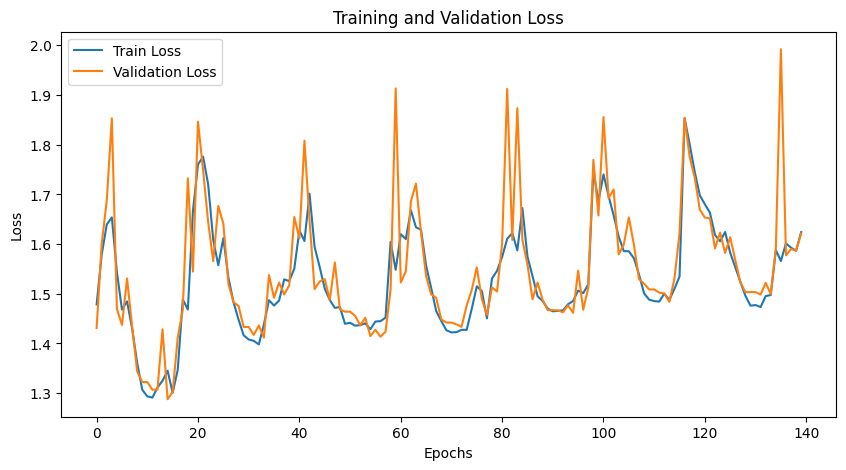

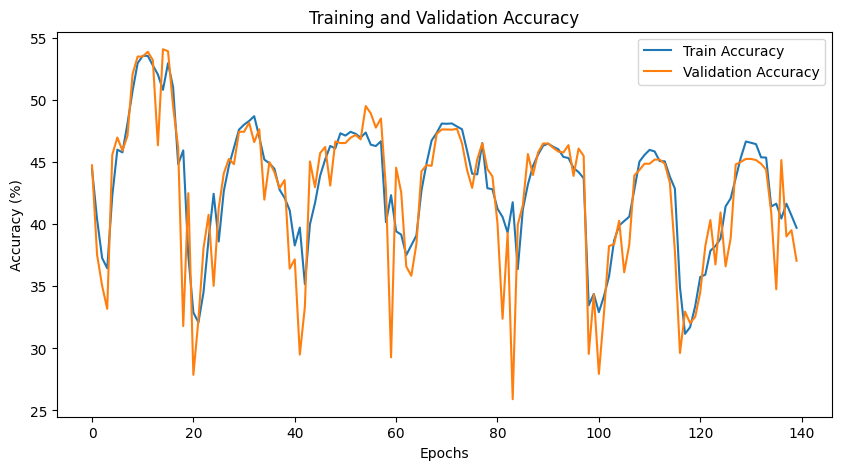

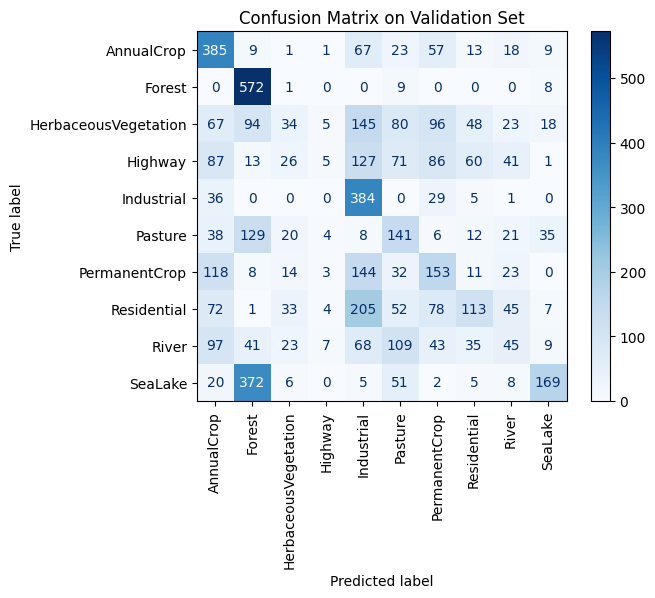

Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.42      0.66      0.51       583
              Forest       0.46      0.97      0.63       590
HerbaceousVegetation       0.22      0.06      0.09       610
             Highway       0.17      0.01      0.02       517
          Industrial       0.33      0.84      0.48       455
             Pasture       0.25      0.34      0.29       414
       PermanentCrop       0.28      0.30      0.29       506
         Residential       0.37      0.19      0.25       610
               River       0.20      0.09      0.13       477
             SeaLake       0.66      0.26      0.38       638

            accuracy                           0.37      5400
           macro avg       0.34      0.37      0.31      5400
        weighted avg       0.35      0.37      0.31      5400



In [ ]:
print("=== MSN ===")##runs out of memory
msn_model, msn_processor = get_msn_model(num_classes)
msn_acc = train_and_evaluate(msn_model, msn_processor, train_loader, valid_loader)

In [ ]:
def get_pvt_model(num_classes):
    import torch
    import torch.nn as nn
    from transformers import AutoImageProcessor, PvtForImageClassification

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    processor = AutoImageProcessor.from_pretrained("Zetatech/pvt-tiny-224")
    model = PvtForImageClassification.from_pretrained(
        "Zetatech/pvt-tiny-224",
        num_labels=num_classes,
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True
    )
    model.to(device)
    return model, processor


=== PVT ===


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/52.9M [00:00<?, ?B/s]

Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-tiny-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([10, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/35]
Train Loss: 1.1156, Train Acc: 57.59%
Val Loss: 0.7155, Val Acc: 74.63%

Epoch [2/35]
Train Loss: 0.6082, Train Acc: 78.91%
Val Loss: 0.5686, Val Acc: 80.72%

Epoch [3/35]
Train Loss: 0.4341, Train Acc: 85.25%
Val Loss: 0.4281, Val Acc: 85.54%

Epoch [4/35]
Train Loss: 0.3401, Train Acc: 88.34%
Val Loss: 0.3160, Val Acc: 89.04%

Epoch [5/35]
Train Loss: 0.2637, Train Acc: 90.93%
Val Loss: 0.3105, Val Acc: 89.56%

Epoch [6/35]
Train Loss: 0.2110, Train Acc: 92.71%
Val Loss: 0.2687, Val Acc: 90.80%

Epoch [7/35]
Train Loss: 0.1466, Train Acc: 94.85%
Val Loss: 0.2084, Val Acc: 93.13%

Epoch [8/35]
Train Loss: 0.0960, Train Acc: 96.70%
Val Loss: 0.1917, Val Acc: 93.30%

Epoch [9/35]
Train Loss: 0.0516, Train Acc: 98.36%
Val Loss: 0.1706, Val Acc: 94.63%

Epoch [10/35]
Train Loss: 0.0239, Train Acc: 99.39%
Val Loss: 0.1724, Val Acc: 94.93%

Epoch [11/35]
Train Loss: 0.0176, Train Acc: 99.65%
Val Loss: 0.1724, Val Acc: 94.93%

Epoch [12/35]
Train Loss: 0.0180, Train Acc: 99.58%


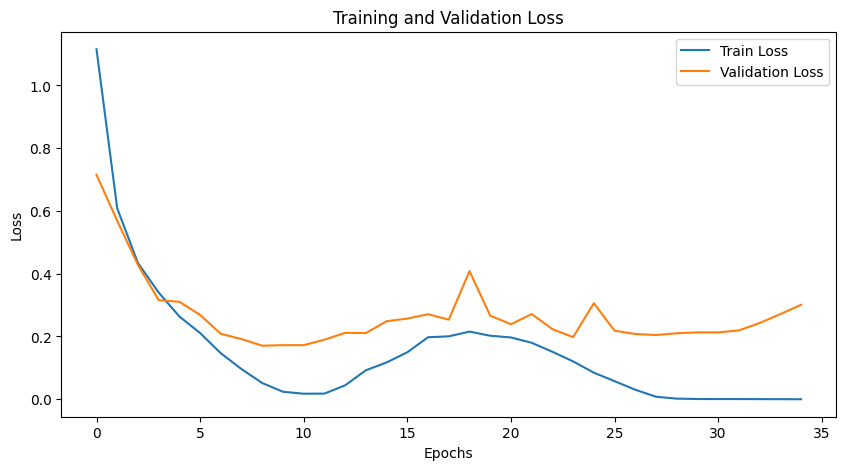

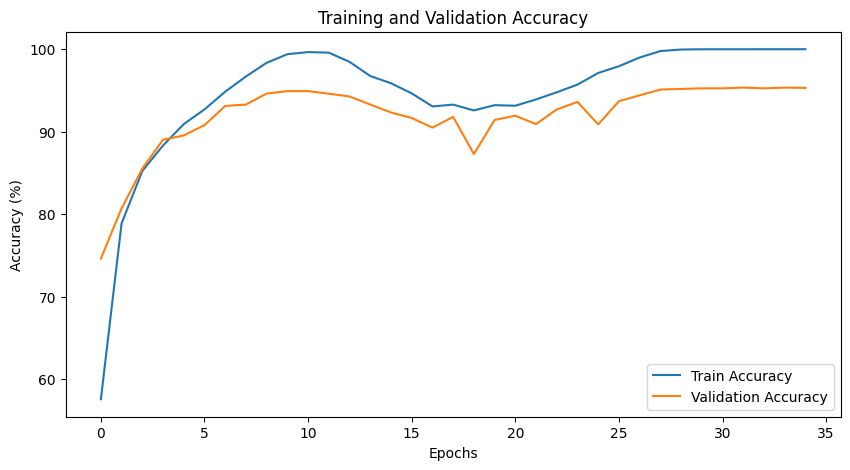

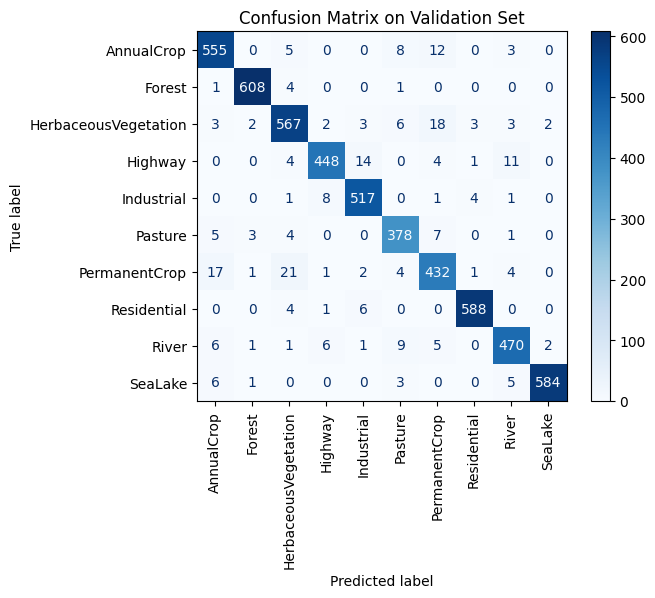

Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.94      0.95      0.94       583
              Forest       0.99      0.99      0.99       614
HerbaceousVegetation       0.93      0.93      0.93       609
             Highway       0.96      0.93      0.95       482
          Industrial       0.95      0.97      0.96       532
             Pasture       0.92      0.95      0.94       398
       PermanentCrop       0.90      0.89      0.90       483
         Residential       0.98      0.98      0.98       599
               River       0.94      0.94      0.94       501
             SeaLake       0.99      0.97      0.98       599

            accuracy                           0.95      5400
           macro avg       0.95      0.95      0.95      5400
        weighted avg       0.95      0.95      0.95      5400

PVT Validation Accuracy: 95.35%


In [ ]:
print("=== PVT ===")
pvt_model, pvt_processor = get_pvt_model(num_classes)
pvt_acc = train_and_evaluate(pvt_model, pvt_processor, train_loader, valid_loader)
print(f"PVT Validation Accuracy: {pvt_acc:.2f}%")

In [ ]:
def get_yolos_small_for_classification(num_classes):

    import torch
    import torch.nn as nn
    from transformers import YolosModel, AutoImageProcessor

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    processor = AutoImageProcessor.from_pretrained("hustvl/yolos-small")
    base_model = YolosModel.from_pretrained("hustvl/yolos-small")

    hidden_size = base_model.config.hidden_size
    classification_head = nn.Linear(hidden_size, num_classes)

    class YOLOSSmallForClassification(nn.Module):
        def __init__(self, base_model, classifier):
            super().__init__()
            self.base_model = base_model
            self.classifier = classifier

        def forward(self, pixel_values, labels=None):
            outputs = self.base_model(pixel_values=pixel_values, return_dict=True)
            pooled_output = outputs.pooler_output  =

            logits = self.classifier(pooled_output)
            loss = None
            if labels is not None:
                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

    model = YOLOSSmallForClassification(base_model, classification_head).to(device)
    return model, processor


In [ ]:
print("=== YOLOS ===")
yolos_model, yolos_processor = get_yolos_small_for_classification(num_classes=num_classes)
yolos_acc = train_and_evaluate(yolos_model, yolos_processor, train_loader, valid_loader)
print(f"YOLOS Validation Accuracy: {yolos_acc:.2f}%")

In [ ]:
def get_mobilevit_model(num_classes):
    import torch
    from transformers import AutoImageProcessor, MobileViTForImageClassification

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")
    model = MobileViTForImageClassification.from_pretrained(
        "apple/mobilevit-small",
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )

    model.config.num_labels = num_classes
    model.config.problem_type = "single_label_classification"
    model.to(device)

    return model, processor


=== MobileViT ===


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/35]
Train Loss: 0.2992, Train Acc: 90.94%
Val Loss: 0.1168, Val Acc: 96.30%

Epoch [2/35]
Train Loss: 0.1450, Train Acc: 95.27%
Val Loss: 0.2149, Val Acc: 93.67%

Epoch [3/35]
Train Loss: 0.1127, Train Acc: 96.34%
Val Loss: 0.1042, Val Acc: 96.33%

Epoch [4/35]
Train Loss: 0.0811, Train Acc: 97.22%
Val Loss: 0.1460, Val Acc: 94.65%

Epoch [5/35]
Train Loss: 0.0593, Train Acc: 97.96%
Val Loss: 0.0775, Val Acc: 97.46%

Epoch [6/35]
Train Loss: 0.0422, Train Acc: 98.59%
Val Loss: 0.0663, Val Acc: 97.81%

Epoch [7/35]
Train Loss: 0.0229, Train Acc: 99.22%
Val Loss: 0.0850, Val Acc: 97.20%

Epoch [8/35]
Train Loss: 0.0143, Train Acc: 99.62%
Val Loss: 0.0423, Val Acc: 98.70%

Epoch [9/35]
Train Loss: 0.0064, Train Acc: 99.83%
Val Loss: 0.0477, Val Acc: 98.50%

Epoch [10/35]
Train Loss: 0.0047, Train Acc: 99.88%
Val Loss: 0.0440, Val Acc: 98.81%

Epoch [11/35]
Train Loss: 0.0034, Train Acc: 99.94%
Val Loss: 0.0446, Val Acc: 98.67%

Epoch [12/35]
Train Loss: 0.0033, Train Acc: 99.94%


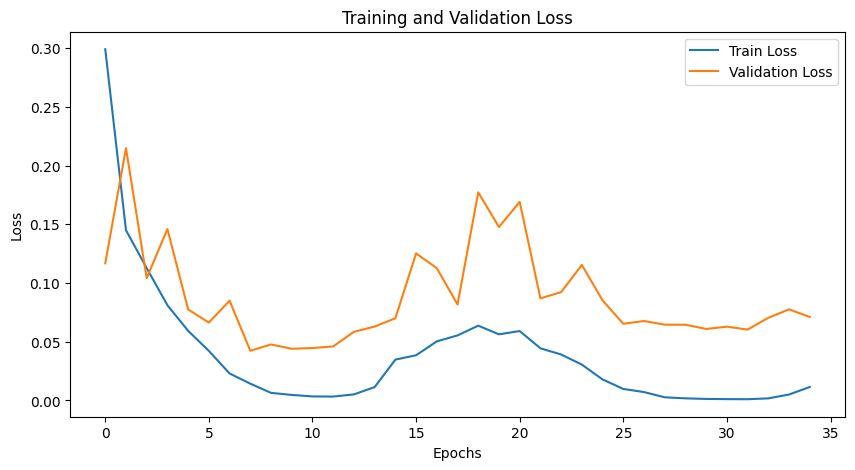

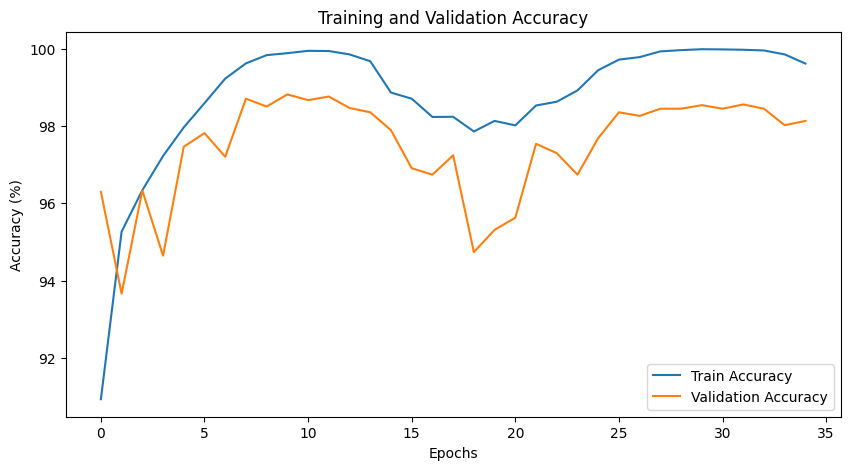

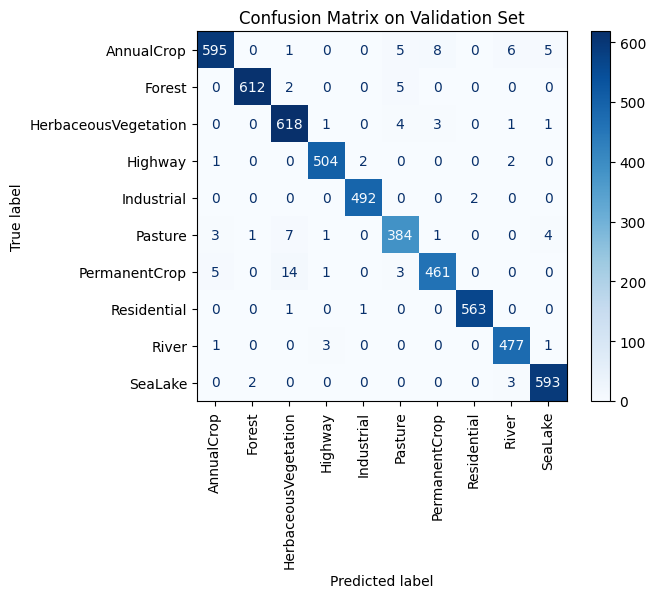

Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.98      0.96      0.97       620
              Forest       1.00      0.99      0.99       619
HerbaceousVegetation       0.96      0.98      0.97       628
             Highway       0.99      0.99      0.99       509
          Industrial       0.99      1.00      0.99       494
             Pasture       0.96      0.96      0.96       401
       PermanentCrop       0.97      0.95      0.96       484
         Residential       1.00      1.00      1.00       565
               River       0.98      0.99      0.98       482
             SeaLake       0.98      0.99      0.99       598

            accuracy                           0.98      5400
           macro avg       0.98      0.98      0.98      5400
        weighted avg       0.98      0.98      0.98      5400

MobileViT Validation Accuracy: 98.81%


In [ ]:
print("=== MobileViT ===")
mobilevit_model, mobilevit_processor = get_mobilevit_model(num_classes)
mobilevit_acc = train_and_evaluate(mobilevit_model, mobilevit_processor, train_loader, valid_loader)
print(f"MobileViT Validation Accuracy: {mobilevit_acc:.2f}%")


In [ ]:
def mobileVit(num_classes):

    import torch
    import torch.nn as nn
    from transformers import MobileViTConfig, MobileViTModel

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")
    base_model = MobileViTModel.from_pretrained("apple/mobilevit-small")

    hidden_size = base_model.config.hidden_state_size
    classification_head = nn.Linear(hidden_size, num_classes)

    class movit(nn.Module):
        def __init__(self, base_model, classifier):
            super().__init__()
            self.base_model = base_model
            self.classifier = classifier

        def forward(self, pixel_values, labels=None):
            outputs = self.base_model(pixel_values=pixel_values, return_dict=True)
            pooled_output = outputs.pooler_output

            logits = self.classifier(pooled_output)
            loss = None
            if labels is not None:
                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

    model = movit(base_model, classification_head).to(device)
    return model, processor


In [ ]:
print("=== movit ===")
movit_model, movit_processor = mobileVit(num_classes=num_classes)
movit_acc = train_and_evaluate(movit_model, movit_processor, train_loader, valid_loader)
print(f"movit Validation Accuracy: {yolos_acc:.2f}%")

=== movit ===


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

AttributeError: 'MobileViTConfig' object has no attribute 'hidden_state_size'